In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
import pandas as pd
import pyfits as pf
%pylab inline
import copy

#from sklearn.datasets import fetch_olivetti_faces
from sklearn.datasets import make_blobs

from sklearn.utils.validation import check_random_state

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import corner

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Load the datasets

data = np.loadtxt('../dat/X.dat')#fetch_olivetti_faces()
targets = np.loadtxt('../dat/Y.dat')#data.target

halfsies = len(data)/2

data = data.reshape((len(data), -1))
# train = data[targets < 30]
# test = data[targets >= 30]  # Test on independent people

In [6]:
print(np.shape(data),np.shape(targets))
print(targets[0])

((41531, 5), (41531, 3))
[  4.05095994e-01   1.04152756e+12   2.21370406e-08]


In [7]:
# Test on a subset of people
n_gals = 1000
rng = check_random_state(4)
gal_ids = rng.randint(halfsies, size=(n_gals, ))
# test = test[face_ids, :]

n_pixels = data.shape[1]
X_train = np.loadtxt('../dat/X_train.dat')#train[:, :np.ceil(0.5 * n_pixels)]  # Upper half of the faces
Y_train = np.loadtxt('../dat/Y_train.dat')#train[:, np.floor(0.5 * n_pixels):]  # Lower half of the faces
X_test = np.loadtxt('../dat/X_test.dat')#test[:, :np.ceil(0.5 * n_pixels)]
Y_test = np.loadtxt('../dat/Y_test.dat')#test[:, np.floor(0.5 * n_pixels):]

In [8]:
# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10, max_features=5,
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

Y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, Y_train)
    Y_test_predict[name] = estimator.predict(X_test)

In [9]:
print(np.shape(X_test),np.shape(Y_test),np.shape(X_train),np.shape(Y_train))
print(np.min(Y_test,axis=0),np.max(Y_test,axis=0))

((25176, 5), (25176, 3), (20765, 5), (20765, 3))
(array([  1.78156998e-02,   1.79120203e+08,   2.53376794e-14]), array([  1.79991996e+00,   1.99489031e+13,   1.00000000e+00]))


In [41]:
def plot_pop_params(i,varname):
    
    colors = 'brgycm'
    
    plt.scatter(Y_test[:,i],Y_test_predict['Extra trees'][:,0],alpha=0.002,color=colors[0])
    plt.scatter(Y_test[:,i],Y_test_predict['K-nn'][:,0],alpha=0.002,color=colors[1])
    plt.scatter(Y_test[:,i],Y_test_predict['Linear regression'][:,0],alpha=0.002,color=colors[2])
    plt.scatter(Y_test[:,i],Y_test_predict['Ridge'][:,0],alpha=0.002,color=colors[3])
#     plt.plot([0.,2.],[0.,2.],color='k',alpha=1.)
    plt.xlabel(r'$'+varname+r'_{true}$')
    plt.ylabel(r'$'+varname+r'_{est}$')
#     plt.xlim(0.,2.)
#     plt.ylim(0.,2.)
    plt.show()


    plt.hist(Y_test[:,0],alpha=0.1,color='k')
    plt.hist(Y_test_predict['Extra trees'][:,i],alpha=0.2,color=colors[0])
    plt.hist(Y_test_predict['K-nn'][:,i],alpha=0.2,color=colors[1])
    plt.hist(Y_test_predict['Linear regression'][:,i],alpha=0.2,color=colors[2])
    plt.hist(Y_test_predict['Ridge'][:,i],alpha=0.2,color=colors[3])
    plt.xlabel(r'$'+varname+r'$')
#     plt.xlim(0.,2.)
    plt.show()

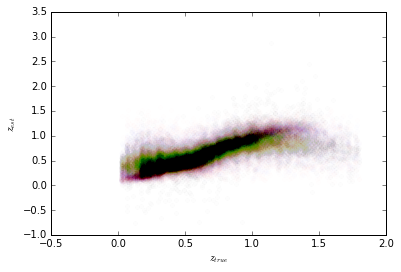

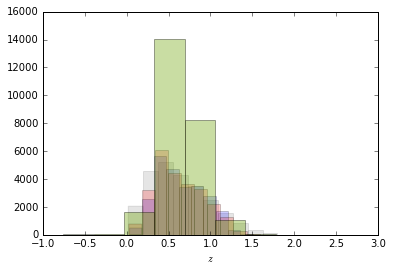

In [42]:
plot_pop_params(0,'z')

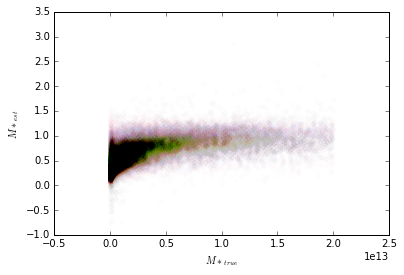

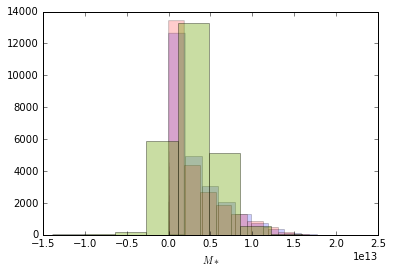

In [43]:
plot_pop_params(1,'M*')

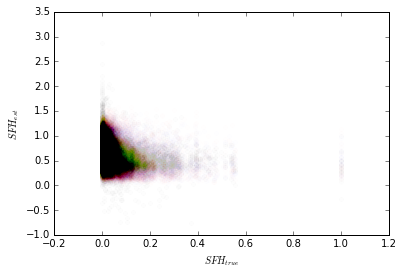

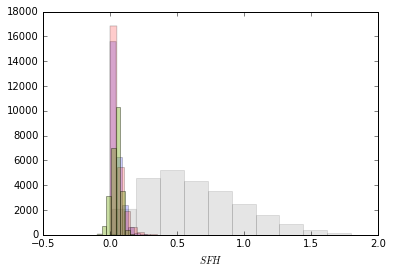

In [44]:
plot_pop_params(2,'SFH')

In [ ]:
def rf(num_bins, num_estimators, num_features=5):
    
    """
    random forrest classifier for determining p(z)'s.
    inputs:
    num_bins = number of redshift bins,
    num_estimators = number of estimators in scikit-learn random forrest classifier,
    num_features = number of photometric features used in
                   photo-z estimation: default:5(colors+mag), 8(colors+mag+5log(angular_size))
                   ,11: everything mentioned so far+ incliniactions.
    outputs:
    label probabilities + best predictions + feature importance
    """
    """ Binning the redshifts"""
    
    nbins = num_bins
    zmin, zmax = min(Y), max(Y)
    binsize = (zmax-zmin)/nbins
    zg = np.linspace(zmin, zmax, nbins)
    
    """ Labeling the bins """
    for i in range(nbins):
      Y[(Y>=zmin)&(Y<zmin*i+binsize)] = i
      Y[Y<1] = 0
        
    """ Splitting the data into training and test sets"""
    
    Y = Y.astype(int)
    half = int(len(Y)/2)
    X_train = X[:half,:num_features]
    Y_train = Y[:half]
    X_test = X[half:,:num_features]
    Y_test = Y[half:]
    
    """ Setting up the RF classifier"""
    clf = RandomForestClassifier(n_estimators=num_estimators, max_depth=None,min_samples_split=1, random_state=0)
    
    """ training """
    clf.fit(X_train, Y_train)
    
    """feature importance """
    fi = clf.feature_importances_
    
    """best predictions"""
    Y_pred = clf.predict(X_test)
    
    """label probabilities"""
    prob = clf.predict_proba(X_test)
    
    return prob, Y_pred, fi

In [ ]:
def plot_corner_mcmc(array):

   
   #prior_min, prior_max = PriorRange('first_try' , Mr)
   prior_range = np.zeros((2,2))
   prior_range[:,0] = np.min(array[:,:2] , axis =0)
   prior_range[:,1] = np.max(array[:,:2] , axis =0)

   fig = corner.corner(
           array[:,:2],
           labels=[
               r'$z$',
               r'$M_{\star}$'
               ],
           label_kwargs={'fontsize': 25},
           range=prior_range,
           quantiles=[0.16,0.5,0.84],
           show_titles=True,
           title_args={"fontsize": 12},
           plot_datapoints=False,
           fill_contours=True,
           levels=[0.68, 0.95],
           color='#ee6a50',
           bins=15)
   fig_name = ''.join(['posterior.pdf'])
   fig.savefig(fig_name, bbox_inches='tight', dpi=150) 
   plt.close()
   return None

In [ ]:
plot_corner_mcmc(y_test_predict['K-nn'])
    

In [ ]:
# Plot the completed faces
#image_shape = (5,3)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.))#n_faces))
plt.suptitle("Galaxy property completion with multi-output estimators", size=16)

#for i in range(n_gals):#(n_faces):
#    true_gal = np.hstack((X_test[i], y_test[i]))
plt.scatter(X_test[],y_test[i],color)

#     if i:
#         sub = plt.subplot(n_gals, n_cols, i * n_cols + 1)
#     else:
#         sub = plt.subplot(n_gals, n_cols, i * n_cols + 1,
#                           title="true galaxies")

#     sub.axis("off")
#     sub.imshow(true_gal,#.reshape(image_shape),
#                cmap=plt.cm.gray,
#                interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_gal = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_gals, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_gals, n_cols, i * n_cols + 2 + j,
                              title=est)

#         sub.axis("off")
#         sub.imshow(completed_gal,#.reshape(image_shape),
#                    cmap=plt.cm.gray,
#                    interpolation="nearest")

plt.show()

print(true_gal,completed_gal)